# About

- Use Langchain to create a summary of an youtube video (in english)
- Use [Falcon](https://huggingface.co/h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2) (fully open source chat model)

In [ ]:
import os
os._exit(00)

In [4]:
%%time

! pip install -qq -U langchain youtube_transcript_api einops
! pip install -qq -U accelerate bitsandbytes xformers

CPU times: user 327 ms, sys: 86.4 ms, total: 413 ms
Wall time: 24.4 s


# Installs & Imports

In [14]:

!pip install torch torchvision --force-reinstall

  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.4 MB/s eta 0:00:0000:0100:01
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 53.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using

In [16]:
from IPython.display import YouTubeVideo

from langchain.document_loaders import YoutubeLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import LLMChain
from langchain.chains.summarize import load_summarize_chain
from langchain.llms import HuggingFacePipeline

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

import torch

import langchain
print(langchain.__version__)

0.2.15


# Video

- Provide the ID of the video
- Just visualize the video in the notebook

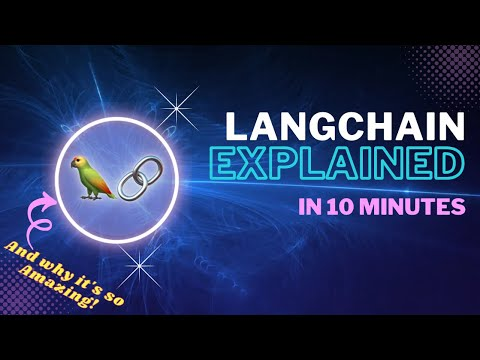

In [17]:
YouTubeVideo('Y_O-x-itHaU', width=700, height=500)

# Load video

With Langchain

In [18]:
loader = YoutubeLoader.from_youtube_url("https://www.youtube.com/watch?v=Y_O-x-itHaU")
transcript = loader.load()

In [19]:
transcript

[Document(metadata={'source': 'Y_O-x-itHaU'}, page_content="land chain is one of the hottest AI Frameworks right now with over 40 000 stars on GitHub as of this video let me help you understand some of the most important aspects of Lang chain and why it's such an amazing library to work with most of us have used chat GPT and are quite fascinated by its capabilities so you can add something like write in this style of Shakespeare how to cook pasta so what happens behind the scenes is that it takes your input and sends it to an AI system as a prompt and that generates a response which is provided back to you and often these systems are called large language models which are trained on a huge amount of text Data from the internet now I want you to imagine a scenario where you are an instructor and you want your students to use chat GPT and submit all of their assignments in the written style of Shakespeare so you can imagine that most of our students are prompting chat GPT to write in thi

# Splitter

In [21]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=50)
texts = text_splitter.split_documents(transcript)

In [22]:
len(texts)

4

# Model

In [23]:
%%time

model_repo = 'h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2'

tokenizer = AutoTokenizer.from_pretrained(model_repo)

model = AutoModelForCausalLM.from_pretrained(model_repo,
                                             load_in_8bit=True,
                                             device_map='auto',
                                             torch_dtype=torch.float16,
                                             low_cpu_mem_usage=True,
                                             trust_remote_code=True
                                            )
max_len = 2048 # 1024
task = "text-generation"
T = 0

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

CPU times: user 5.08 s, sys: 13.6 s, total: 18.7 s
Wall time: 58.1 s


In [24]:
pipe = pipeline(
    task=task,
    model=model, 
    tokenizer=tokenizer, 
    max_length=max_len,
    temperature=T,
    top_p=0.95,
    repetition_penalty=1.15,
    pad_token_id = 11
)

llm = HuggingFacePipeline(pipeline=pipe)

/opt/conda/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/opt/conda/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
The model 'RWForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntF

# Summarize chain

There are three options for chain_type: 
- "stuff"
- "map_reduce"
- "refine"

## Default prompt template

In [25]:
chain = load_summarize_chain(llm=llm, chain_type="map_reduce", verbose=True)

In [26]:
chain

MapReduceDocumentsChain(verbose=True, llm_chain=LLMChain(verbose=True, prompt=PromptTemplate(input_variables=['text'], template='Write a concise summary of the following:\n\n\n"{text}"\n\n\nCONCISE SUMMARY:'), llm=HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x79f59427f9d0>)), reduce_documents_chain=ReduceDocumentsChain(verbose=True, combine_documents_chain=StuffDocumentsChain(verbose=True, llm_chain=LLMChain(verbose=True, prompt=PromptTemplate(input_variables=['text'], template='Write a concise summary of the following:\n\n\n"{text}"\n\n\nCONCISE SUMMARY:'), llm=HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x79f59427f9d0>)), document_variable_name='text')), document_variable_name='text')

In [27]:
### default prompt template
chain.llm_chain.prompt.template

'Write a concise summary of the following:\n\n\n"{text}"\n\n\nCONCISE SUMMARY:'

In [28]:
%%time

# Run the chain with verbose=True
summary = chain.run(texts)
summary

<timed exec>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.




> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"land chain is one of the hottest AI Frameworks right now with over 40 000 stars on GitHub as of this video let me help you understand some of the most important aspects of Lang chain and why it's such an amazing library to work with most of us have used chat GPT and are quite fascinated by its capabilities so you can add something like write in this style of Shakespeare how to cook pasta so what happens behind the scenes is that it takes your input and sends it to an AI system as a prompt and that generates a response which is provided back to you and often these systems are called large language models which are trained on a huge amount of text Data from the internet now I want you to imagine a scenario where you are an instructor and you want your students to use chat GPT and submit all of their assignments in the written style of 

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2395 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2378 > 2048). Running this sequence through the model will result in indexing errors
Input length of input_ids is 2378, but `max_length` is set to 2048. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.




> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"Write a concise summary of the following:


"land chain is one of the hottest AI Frameworks right now with over 40 000 stars on GitHub as of this video let me help you understand some of the most important aspects of Lang chain and why it's such an amazing library to work with most of us have used chat GPT and are quite fascinated by its capabilities so you can add something like write in this style of Shakespeare how to cook pasta so what happens behind the scenes is that it takes your input and sends it to an AI system as a prompt and that generates a response which is provided back to you and often these systems are called large language models which are trained on a huge amount of text Data from the internet now I want you to imagine a scenario where you are an instructor and you want your students to use chat GPT and submit all of their assignments in the written style of Shake

'Write a concise summary of the following:\n\n\n"Write a concise summary of the following:\n\n\n"land chain is one of the hottest AI Frameworks right now with over 40 000 stars on GitHub as of this video let me help you understand some of the most important aspects of Lang chain and why it\'s such an amazing library to work with most of us have used chat GPT and are quite fascinated by its capabilities so you can add something like write in this style of Shakespeare how to cook pasta so what happens behind the scenes is that it takes your input and sends it to an AI system as a prompt and that generates a response which is provided back to you and often these systems are called large language models which are trained on a huge amount of text Data from the internet now I want you to imagine a scenario where you are an instructor and you want your students to use chat GPT and submit all of their assignments in the written style of Shakespeare so you can imagine that most of our students 

In [29]:
len(summary)

11950

## Custom prompt template

In [31]:
chain2 = load_summarize_chain(llm=llm, chain_type="map_reduce", verbose=False)

In [32]:
### change the prompt template
chain2.llm_chain.prompt.template = \
"""Write a three paragraph summary the following:


"{text}"


3 PARAGRAPH SUMMARY:"""

In [33]:
%%time

# Run the chain  with verbose=False
summary = chain2.run(texts)
summary

Input length of input_ids is 2279, but `max_length` is set to 2048. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


CPU times: user 4min 18s, sys: 0 ns, total: 4min 18s
Wall time: 4min 18s


'Write a three paragraph summary the following:\n\n\n"Write a three paragraph summary the following:\n\n\n"land chain is one of the hottest AI Frameworks right now with over 40 000 stars on GitHub as of this video let me help you understand some of the most important aspects of Lang chain and why it\'s such an amazing library to work with most of us have used chat GPT and are quite fascinated by its capabilities so you can add something like write in this style of Shakespeare how to cook pasta so what happens behind the scenes is that it takes your input and sends it to an AI system as a prompt and that generates a response which is provided back to you and often these systems are called large language models which are trained on a huge amount of text Data from the internet now I want you to imagine a scenario where you are an instructor and you want your students to use chat GPT and submit all of their assignments in the written style of Shakespeare so you can imagine that most of our

In [34]:
len(summary)

11567